In [4]:
!pip install pathway

    
    
    
    

Model 1: Baseline Linear Model

Sample dataset generated and saved as dataset_model1.csv


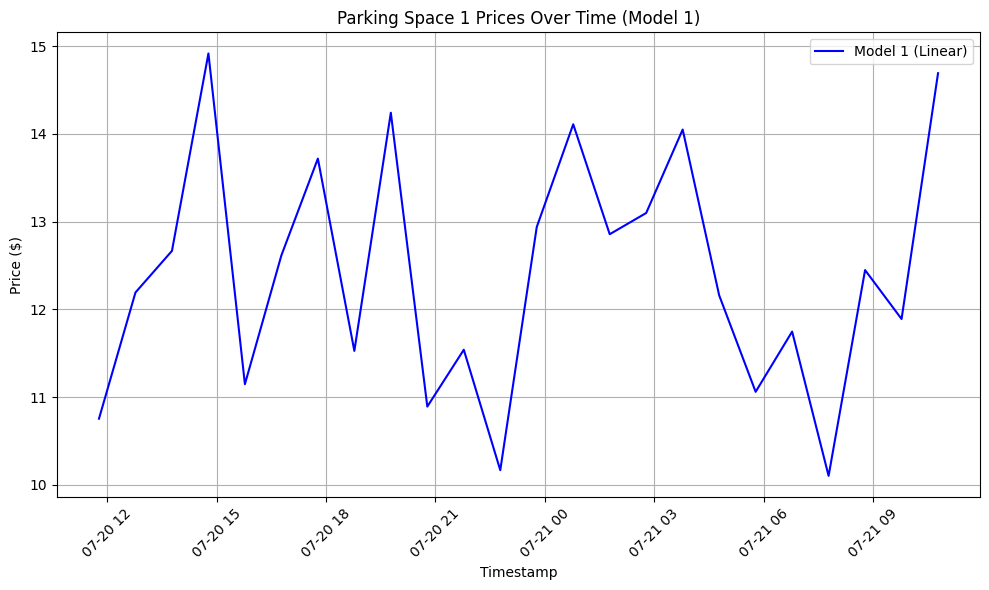

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Step 1: Generate sample data
def generate_sample_data():
    # Create sample data without using Pathway
    timestamps = [(datetime.now() + timedelta(hours=i)).strftime("%Y-%m-%d %H:%M:%S") for i in range(24)]
    data = {
        "timestamp": timestamps * 5,
        "space_id": [i for i in range(1, 6) for _ in range(24)],
        "occupancy": np.random.uniform(0, 1, 24 * 5)
    }
    df = pd.DataFrame(data)
    df.to_csv("dataset_model1.csv", index=False)
    return df

# Generate sample data
df = generate_sample_data()
print("Sample dataset generated and saved as dataset_model1.csv")

# Step 2: Define pricing model
def baseline_model(occupancy):
    """
    Model 1: Linear model based on occupancy.
    Price = Base Price + (Occupancy * Scaling Factor)
    """
    base_price = 10.0
    scaling_factor = 5.0
    price = base_price + (occupancy * scaling_factor)
    return max(5.0, min(20.0, price))  # Cap price between $5 and $20

# Step 4: Process data using pandas instead of Pathway
def run_pricing_pipeline():
    """
    Process data and compute prices for Model 1 using pandas.
    Outputs results to output_prices_model1.csv.
    """
    data = pd.read_csv("dataset_model1.csv")
    
    # Apply pricing model
    data['price_model1'] = data['occupancy'].apply(baseline_model)
    
    # Select relevant columns
    prices = data[['space_id', 'timestamp', 'price_model1']]
    
    prices.to_csv("output_prices_model1.csv", index=False)
    return prices

# Step 5: Visualization with Matplotlib
def plot_prices():
    """
    Create Matplotlib plot for Model 1 prices for space_id=1.
    """
    df_out = pd.read_csv("output_prices_model1.csv")
    df_out['timestamp'] = pd.to_datetime(df_out['timestamp'])
    
    df_space1 = df_out[df_out["space_id"] == 1]
    
    plt.figure(figsize=(10, 6))
    plt.plot(df_space1["timestamp"], df_space1["price_model1"], label="Model 1 (Linear)", color="blue")
    plt.title("Parking Space 1 Prices Over Time (Model 1)")
    plt.xlabel("Timestamp")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Step 6: Run the pipeline and visualize
if __name__ == "__main__":
    run_pricing_pipeline()
    plot_prices()

Model 2: Enhanced Model

In [8]:
# Load the dataset from the correct path
df = pd.read_csv(r"C:\Users\boopa\Downloads\dataset.csv")

# Combine date and time into a single datetime column
df['LastUpdated'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')

# Extract time-based features
df['Hour'] = df['LastUpdated'].dt.hour
df['DayOfWeek'] = df['LastUpdated'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# Calculate OccupancyRate
df['OccupancyRate'] = (df['Occupancy'] / df['Capacity']) * 100

# Encode categorical variables
le_vehicle = LabelEncoder()
le_traffic = LabelEncoder()
df['VehicleType'] = le_vehicle.fit_transform(df['VehicleType'])
df['TrafficConditionNearby'] = le_traffic.fit_transform(df['TrafficConditionNearby'])

# Select features and target
features = ['VehicleType', 'TrafficConditionNearby', 'IsSpecialDay', 'Hour', 'DayOfWeek', 'IsWeekend', 'QueueLength']
X = df[features]
y = df['OccupancyRate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print('\nFeature Importance:')
print(feature_importance)

# Example prediction for a new data point
example = pd.DataFrame([{
    'VehicleType': le_vehicle.transform(['car'])[0],
    'TrafficConditionNearby': le_traffic.transform(['average'])[0],
    'IsSpecialDay': 0,
    'Hour': 12,
    'DayOfWeek': 2,
    'IsWeekend': 0,
    'QueueLength': 5
}])
predicted_occupancy = model.predict(example)[0]
print(f'\nPredicted Occupancy Rate for example: {predicted_occupancy:.2f}%')

Mean Squared Error: 425.15
R2 Score: 0.31

Feature Importance:
                  Feature  Importance
3                    Hour    0.464650
4               DayOfWeek    0.176654
6             QueueLength    0.138807
0             VehicleType    0.088075
5               IsWeekend    0.085008
1  TrafficConditionNearby    0.035556
2            IsSpecialDay    0.011251

Predicted Occupancy Rate for example: 42.62%
